In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}


In [2]:
gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_99406/4109629132.py:1: DtypeWarning: Columns (9,11,12,13,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  gwas = pd.read_csv('gwas_catalog_v1.0.2-associations_e113_r2025-03-08.tsv', sep='\t')


In [3]:
# Clean up MAPPED_GENE column
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split(',').str[0]
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split(' - ').str[0]
gwas['MAPPED_GENE'] = gwas['MAPPED_GENE'].str.split('-').str[0]



In [4]:
gwas[['REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID',]]

,REPORTED GENE(S),MAPPED_GENE,UPSTREAM_GENE_ID,DOWNSTREAM_GENE_ID
0,"SEPT5, GP1BB",GP1BB,NaN,NaN
1,ARVCF,ARVCF,NaN,NaN
2,MN1,MN1,NaN,NaN
3,EWSR1,EWSR1,NaN,NaN
4,TMPRSS6,NaN,NaN,NaN
...,...,...,...,...
788647,NaN,FADS2,NaN,NaN
788648,NaN,FADS2,NaN,NaN
788649,NaN,FADS2,NaN,NaN
788650,NaN,FADS2,NaN,NaN


In [5]:
# Map meta traits:

# Mapp traits to understandbale traits
mapping_dict = {
    'Glucose': ['glucose measurement', 'BMI-adjusted fasting blood glucose measurement'],
    'Insulin': ['blood insulin amount', 'insulin measurement', 'BMI-adjusted fasting blood insulin measurement',
                 'Headache, blood insulin amount',],
    #'Lactate': ['lactate measurement', ],
    #'Fatty acid': ['fatty acid measurement', 'polyunsaturated fatty acid measurement','saturated fatty acids measurement '],
    #'Ketones': ['Ketonuria', 'acetoacetate measurement','3-hydroxybutyrate measurement'],
    'Type 2 diabetes': ['type 2 diabetes mellitus',],
    'HOMA-B': ['HOMA-B',],
    'HOMA-IR': ['HOMA-IR',],
}


item_to_class = {item: cls for cls, items in mapping_dict.items() for item in items}

gwas["TRAIT_CLASS"] = gwas["MAPPED_TRAIT"].map(item_to_class)

gwas = gwas[gwas["TRAIT_CLASS"].notna()]

In [6]:
# Parse the initial smaple size field into number and ethinicity
import re
gwas['SAMPLE_SIZE'] = gwas['INITIAL SAMPLE SIZE'].apply(lambda entry: sum([int(i) for i in re.findall(r'\d+', entry.replace(',',''))]) if type(entry) == str  else np.nan)


In [7]:
# Filter out associations with p-value > 5e-8 
gwas = gwas[gwas["P-VALUE"] > 5e-8]

#Filter out studies with less than 50K participants
gwas = gwas[gwas['SAMPLE_SIZE'] > 50000]

In [8]:
N_STUDIES_TRAITS = gwas.groupby(['TRAIT_CLASS','MAPPED_GENE'])['PUBMEDID'].nunique().reset_index()
N_STUDIES_TRAITS = N_STUDIES_TRAITS.pivot(columns='TRAIT_CLASS',index='MAPPED_GENE')
N_STUDIES_TRAITS.columns = N_STUDIES_TRAITS.columns.droplevel(0)


N_STUDIES = gwas.groupby(['TRAIT_CLASS'])['PUBMEDID'].nunique()

NORM_N_STUDIES_TRAITS =  N_STUDIES_TRAITS.div(N_STUDIES, axis=1)
NORM_N_STUDIES_TRAITS.shape

(388, 3)

In [12]:
# Find model related genes: 
NORM_N_STUDIES_TRAITS.to_csv('Genes.csv')

<Axes: xlabel='TRAIT_CLASS', ylabel='MAPPED_GENE'>

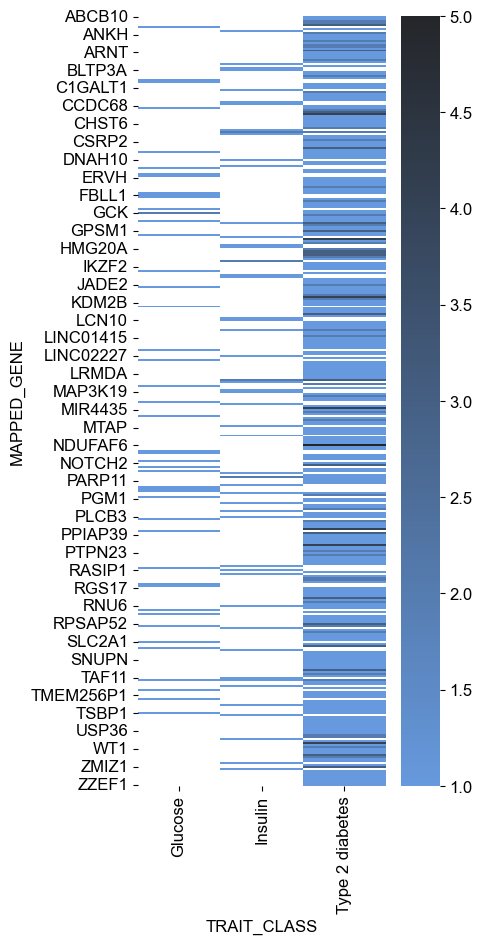

In [13]:
f,ax = plt.subplots(1,1, figsize=(4,10))
cm = sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.heatmap(N_STUDIES_TRAITS.loc[:,:], cmap=cm, ax=ax)